# GAN 인 액션

#### 손글씨 숫자 생성하기

3-1 모듈 임포트

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

3-2 모델 입력 차원

In [5]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) #입력 이미지 차원

z_dim = 100                                #생성자의 입력으로 사용될 잡음 벡터의 크기

은닉층은 LeakyReLU 활성화 함수를 사용한다. 음수 입력을 모두 0으로 만드는 일반적인 ReLU 함수와 달리 LeakyReLU는 작은 기울기를 사용한다.\
이 함수는 훈련 중에 그레디언트가 사라지는 것을 막기 때문에 훈련 결과를 향상시키는 경향이 있다.

출력 층에는 tanh 활성화 함수를 사용하여 출력 값을 [-1, 1] 범위로 조정한다.\
tanh를 사용하는 이유는 (0과 1범위로 출력하는 일반적인 시그모이드 함수보다) 조금 더 또렷한 이미지를 만들기 때문이다.

3-3 생성자

In [6]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim = z_dim))             #완전 연결층
    model.add(LeakyReLU(alpha=0.01))                     #LeakyReLU 활성화 함수
    model.add(Dense(28 * 28 * 1, activation = 'tanh'))   #tanh 활성화 함수를 사용한 출력층
    model.add(Reshape(img_shape))                        #생성자 출력을 이미지 차원으로 변경
    return model

판별자는 28 x 28 x 1 크기의 이미지를 받아 가짜와 비교해 얼마나 진짜인지를 나타내는 확률을 출력한다.\
판별자는 2개의 층으로 구성된 네트워크이다. 은닉층은 LeakyReLU 활성화 함수와 128개의 은닉 유닛을 가진다.

3-4 판별자

In [7]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape = img_shape))   #입력 이미지를 일렬로 펼치기
    model.add(Dense(128))                         #완전 연결층
    model.add(LeakyReLU(alpha=0.01))              #LeakyReLU 활성화 함수
    model.add(Dense(1, activation = 'sigmoid'))   #시그모이드 활성화 함수를 사용한 출력층
    return model

생성자를 훈련하기 위해 연결된 모델에서는 판별자의 파라미터를 동결하기 위해 discriminator.trainable을 False로 지정.\
판별자를 훈련하지 않도록 설정한 이 연결된 모델은 생서앚만 훈련하기 위해 사용된다.\
판별자는 독립적으로 컴파일된 모델로 훈련

이진 교차 엔트로피를 훈련하는 동안 최소화할 손실 함수로 사용한다. 이진 교차 엔트로피는 두 개의 클래스만 있는 예측에서 계산된 확률과 진짜 확률 사이의 차이를 측정\
교차 엔트로피 손실이 클수록 예측이 정답 레이블과 차이가 크다.

각 네트워크를 최적화하기 위해 Adam 최적화 알고리즘을 사용.

3-5 모델 만들기와 컴파일

In [8]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    model.add(generator)                              # 생성자 + 판별자 모델 연결
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)        #판별자 모델 만들고 컴파일하기
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)         #생성자 모델 만들기

discriminator.trainable = False                       #생성자 훈련할 때 판별자 파라미터 동결하기

gan = build_gan(generator, discriminator)             #생성자를 훈련하기 위해 동결한 판별자로 GAN 모델 만들고 컴파일하기
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

원-핫 인코딩된 레이블을 사용, 1은 진짜 이미지, 0은 가짜 이미지.\
준정규분포(평균이 0이고 표준편차라 1인 종 모양의 곡선)에서 샘프링하여 z 벡터를 생성\
판별자는 가짜 이미지에 0 레이블을 할당하고 진짜 이미지에 1 레이블을 할당하도록 훈련된다.\
생성자는 자신이 만든 가짜 샘플에 판별자가 1 레이블을 할당하게끔 훈련된다.

훈련 데이터셋에 있는 진짜 이미지를 -1에서 1까지 범위로 스케일을 조정했다.\
앞서 코드에서 보았듯, 생성자는 출력층에 tanh 활성화 함수를 사용하기 때문에 가짜 이미지는(-1, 1)범위의 값을 가진다.\
따라서 모든 판별자의 입력을 동일한 범위로 바꿔야 한다.

3-6 GAN 훈련 반복

In [13]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteration, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data()                           #MNIST 데이터셋 로드
    
    X_train = X_train / 127.5 - 1.0                                    #[0, 255]흑백 픽셀 값을 [-1, 1]사이로 스케일 조정
    X_train = np.expand_dims(X_train, axis=3)                                  
    
    real = np.ones((batch_size, 1))                                    #진짜 이미지 레이블: 모두 1
    
    fake = np.zeros((batch_size, 1))                                   #가짜 이미지 레이블: 모두 0
    
    for iteration in range(iteration):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)       #진짜 이미지에서 랜덤 배치 가져오기
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))                  #가짜 이미지 배치 생성
        gen_imgs = generator.predict(z) 
        
        d_loss_real = discriminator.train_on_batch(imgs, real)         #판별자 훈련
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake) 
        
        z = np.random.normal(0, 1, (batch_size, 100))                  #가짜 이미지 배치 생성
        
        g_loss = gan.train_on_batch(z, real)                           #생성자 훈련
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))                            #훈련이 끝난 후 그래프를 그리기위해 손실과 정확도 저장
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))  # 훈련과정 출력
            
            sample_images(generator)                                   # 생성된 이미지 샘플 출력

3-7 샘플 이미지 출력

In [14]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize = (4, 4),
                            sharey=True,
                            sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

3-8 모델 실행

4/4 [==============================] - 0s 2ms/step
1000 [D 손실: 0.049283, 정확도: 100.00%] [G 손실: 3.662234]
4/4 [==============================] - 0s 2ms/step
2000 [D 손실: 0.150440, 정확도: 95.70%] [G 손실: 4.132782]
4/4 [==============================] - 0s 2ms/step
3000 [D 손실: 0.081064, 정확도: 98.05%] [G 손실: 3.965882]
4/4 [==============================] - 0s 2ms/step
4000 [D 손실: 0.062260, 정확도: 97.66%] [G 손실: 6.288011]
4/4 [==============================] - 0s 2ms/step
5000 [D 손실: 0.173937, 정확도: 91.41%] [G 손실: 5.453025]
4/4 [==============================] - 0s 3ms/step
6000 [D 손실: 0.329137, 정확도: 87.11%] [G 손실: 3.513136]
4/4 [==============================] - 0s 3ms/step
7000 [D 손실: 0.282384, 정확도: 91.02%] [G 손실: 3.743896]
4/4 [==============================] - 0s 3ms/step
8000 [D 손실: 0.210865, 정확도: 91.41%] [G 손실: 3.688394]
4/4 [==============================] - 0s 4ms/step
9000 [D 손실: 0.276594, 정확도: 89.45%] [G 손실: 3.838863]
4/4 [==============================] - 0s 3ms/step
10000 [D 손실: 0.268085

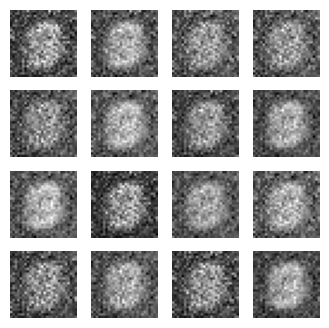

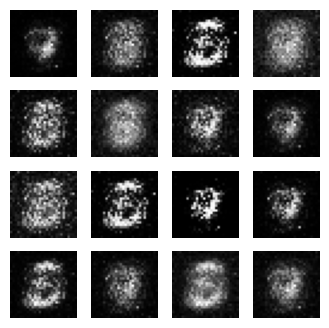

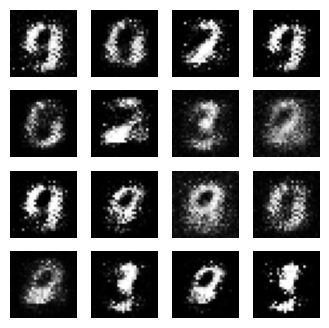

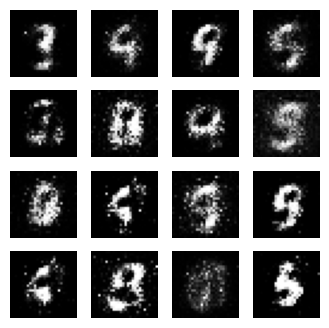

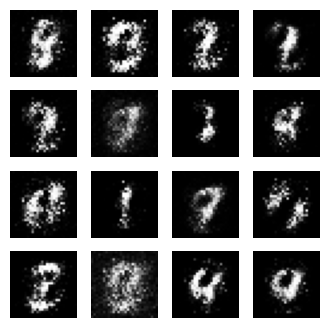

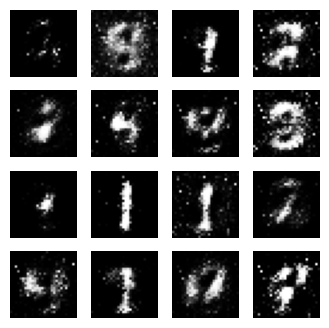

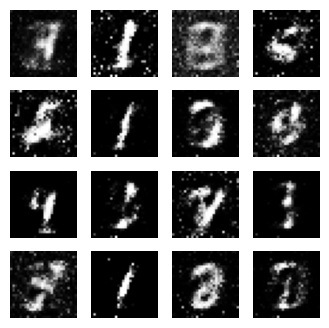

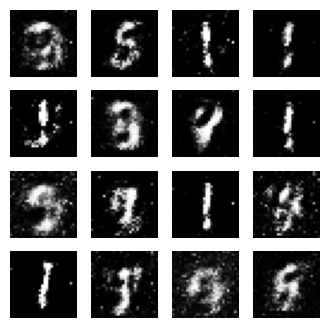

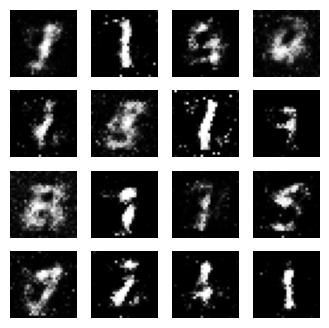

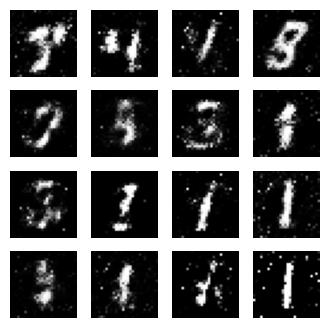

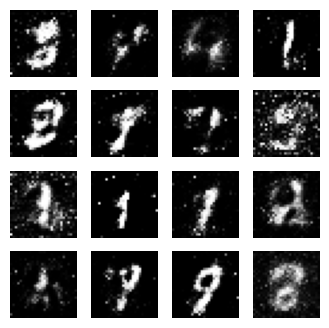

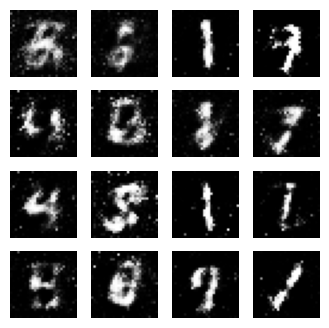

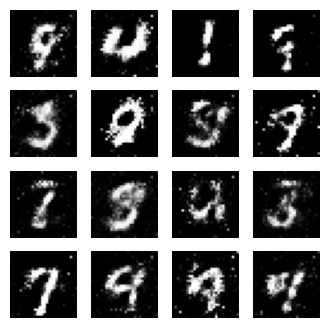

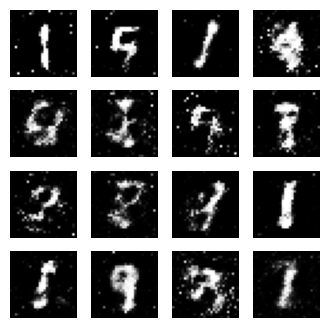

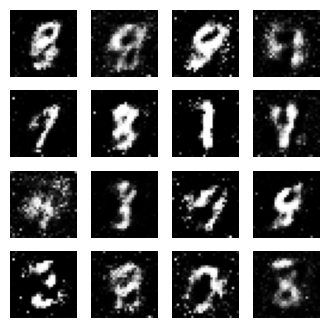

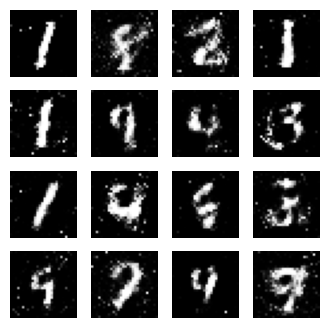

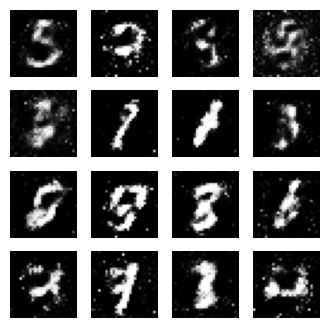

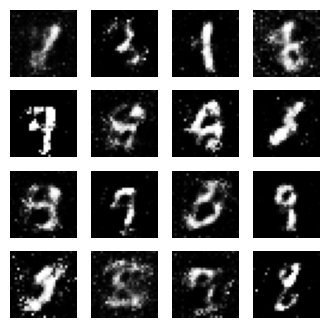

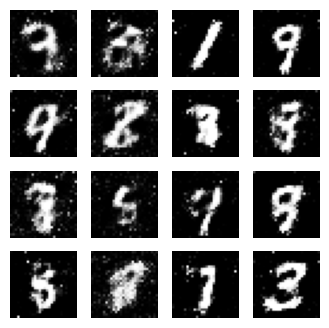

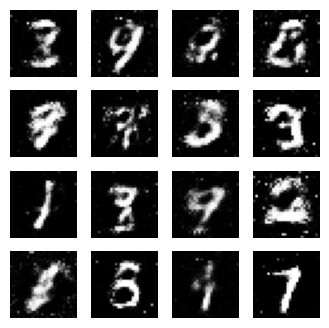

In [15]:
iterations = 20000                                 #하이퍼파라미터 설정
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)     #지정된 횟수 동안 GAN 훈련

결론

GAN이 생성한 이미지가 완벽하지는 않지만 여러 개는 진짜 수자처럼 보임.\
생성자와 판별자에 2개의 층이 있는 간단한 신경망 구조를 사용하여 놀라운 성과를 내었다\

* GAN은 생성자(G)와 판별자(D) 두 개의 네트워크로 구성된다. 두 네트워크는 각자의 손실 함수를 가지고 있다. J(G)(θ(G), θ(D))와 J(D)(θ(G), θ(D))이다.
* 훈련하는 동안 생성자와 판별자는 자신의 파라미터인 θ(G)와 θ(D)만 조정할 수 있다.
* GAN의 두 네트워크는 게임 같은 방식으로 동시에 훈련된다. 생성자는 판별자의 거짓 양성 분류가 최대가 되게 한다(즉 생성된 이미지를 진짜로 분류한다).\
반면 판별자는 거짓 양성과 거짓 음성 분류를 최소화하기를 원한다.